# gpOptimizer Multi-Task Test
At first we have to install the newest version of gpCAM

In [1]:
## First, install the newest version of gpcam
#!pip install gpCAM==8.3.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import fvGPOptimizer
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
from itertools import product
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

## Simple 1d Example

### Data

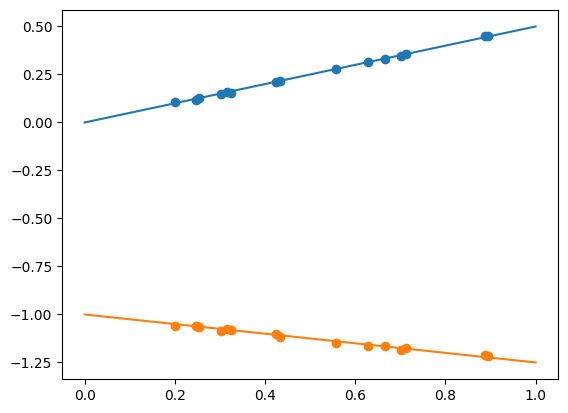

In [3]:
def f1(x): return 0.5 * x
def f2(x): return (-.25 * x) - 1.

x_pred1d = np.linspace(0,1,50)
plt.plot(x_pred1d,f1(x_pred1d))
plt.plot(x_pred1d,f2(x_pred1d))
x_data = np.random.rand(15)
y_data1 = f1(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
y_data2 = f2(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.show()

### GP initialization

In [4]:
my_gp2 = fvGPOptimizer(x_data.reshape(len(x_data),1), np.column_stack([y_data1, y_data2]))
print("Hybrid Training in progress")
my_gp2.train(max_iter = 20, method = "hgdl", dask_client=client)

print("MCMC Training in progress")
my_gp2.train(max_iter = 20, method = "mcmc")

print("Local Training in progress")
my_gp2.train(max_iter = 20, method = "local")

print("Global Training in progress")
my_gp2.train(max_iter = 20, method="global")

/home/marcus/Coding/fvGP/fvgp/gp.py:249: UserWarning:

Hyperparameters initialized to a vector of ones.

/home/marcus/Coding/fvGP/fvgp/gp.py:295: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.

/home/marcus/Coding/fvGP/fvgp/gp.py:558: UserWarning:

Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions



Hybrid Training in progress
MCMC Training in progress
Local Training in progress
Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:558: UserWarning:

Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions



array([0.89150464, 6.94660737, 0.01      ])

### Predictions

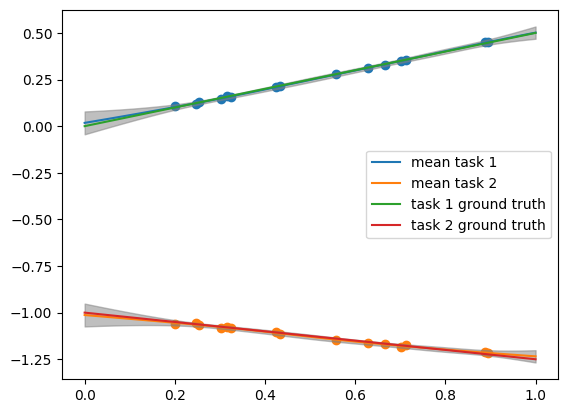

In [5]:
#mean and standard deviation
mean = my_gp2.posterior_mean(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["m(x)"]
std = np.sqrt(my_gp2.posterior_covariance(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["v(x)"])

plt.plot(x_pred1d.reshape(50,1),mean[:,0], label = "mean task 1")
plt.plot(x_pred1d.reshape(50,1),mean[:,1], label = "mean task 2")
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.plot(x_pred1d,f1(x_pred1d), label = "task 1 ground truth")
plt.plot(x_pred1d,f2(x_pred1d), label = "task 2 ground truth")
plt.fill_between(x_pred1d, mean[:,0] - 3. * std[:,0], mean[:,0] + 3. * std[:,0], alpha = 0.5, color = "grey")
plt.fill_between(x_pred1d, mean[:,1] - 3. * std[:,1], mean[:,1] + 3. * std[:,1], alpha = 0.5, color = "grey")
plt.legend()
plt.show()

### ask()ing for new actions

In [6]:
print("asking for the best 2 candidates out of 3:")
print(my_gp2.ask([np.array([0.0]), np.array([0.2]), np.array([1.])], n=2))

print("asking for the best new suggestion across the space [0,1], vectorized=True (default):")
print(my_gp2.ask(np.array([[0.,1.]]), n=1))

print("asking for the best new suggestion across the space [0,1], with vectorization for the global optimizer:")
print(my_gp2.ask(np.array([[0.,1.]]), n=1, vectorized = False))

print("asking for the best new 4 suggestions across the space [0,1] with total correlation:")
print(my_gp2.ask(np.array([[0.,1.]]), n=4, vectorized = False, acquisition_function="total correlation"))

print("asking for an optimized result")
print(my_gp2.ask(np.array([[0.,1.]]), n=30, method = "hgdl", max_iter=100, dask_client=client))

asking for the best 2 candidates out of 3:
{'x': array([[0.],
       [1.]]), 'f_a(x)': array([0.00083517, 0.00024068]), 'opt_obj': None}
asking for the best new suggestion across the space [0,1], vectorized=True (default):
{'x': array([[3.63350512e-06]]), 'f_a(x)': array([0.00083514]), 'opt_obj': None}
asking for the best new suggestion across the space [0,1], with vectorization for the global optimizer:
{'x': array([[7.14914616e-07]]), 'f_a(x)': array([0.00083516]), 'opt_obj': None}
asking for the best new 4 suggestions across the space [0,1] with total correlation:


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer_base.py:425: UserWarning:

Set vectorized=False for total corr. or rel. inf. entropy.



{'x': array([[9.97682882e-01],
       [8.43870887e-02],
       [2.94542528e-04],
       [8.25577358e-01]]), 'f_a(x)': array([-44.80156946]), 'opt_obj': None}
asking for an optimized result
[[0.        ]
 [0.        ]
 [0.27330693]] [0 2]
{'x': array([[0.        ],
       [0.27330693]]), 'f_a(x)': array([8.35165668e-04, 1.63609513e-05]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f33b834e710>}


/home/marcus/Coding/gpCAM/gpcam/surrogate_model.py:118: UserWarning:

An insufficient number of unique optima identified. Try `total correlation` or the use of candidates by providing them as a list to ask(). 



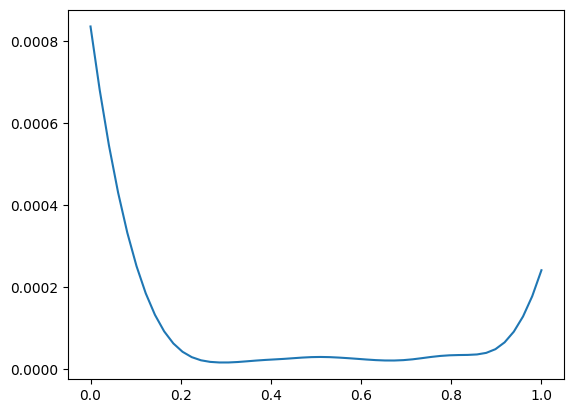

In [7]:
plt.plot(x_pred1d, my_gp2.evaluate_acquisition_function(x_pred1d))

In [8]:
#more ask()s to test:
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)

my_gp2.ask(np.array([[0.,1.]]), n = 4, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 5, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 6, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 2, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer_base.py:421: UserWarning:

You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'.



{'x': array([[9.99948752e-01],
        [2.47933568e-04]]),
 'f_a(x)': array([-20.67668616]),
 'opt_obj': None}

## Communicating data points with missing tasks as lists

In [9]:
y_data = np.column_stack([y_data1, y_data2])
noise_variances = np.zeros(y_data.shape) + 0.01
y_data[2,0] = np.nan
noise_variances[2,0] = np.nan

y_data[6,1] = np.nan
noise_variances[6,1] = np.nan



my_gp2 = fvGPOptimizer(x_data.reshape(len(x_data),1), y_data, noise_variances=noise_variances)
print("Global Training in progress")
my_gp2.train(max_iter = 20)

Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:249: UserWarning:

Hyperparameters initialized to a vector of ones.



array([0.37054036, 3.0819856 , 0.50360757])

# 2d Example

### Data

In [10]:
data = np.load("./data/sim_variable_mod.npy")
sparsification = 4

x_data3 = data[:,5:][::sparsification]
y_data3 = data[:,0:2][::sparsification]

#it is good practice to check the format of the data
print(x_data3.shape)
print(y_data3.shape)

(1583, 3)
(1583, 2)


In [11]:
index = np.where(x_data3[:,2] == 1200.)[0]
x_data3=x_data3[index,0:2]
y_data3=y_data3[index]

In [12]:
for i in range(x_data3.shape[1]):
    x_data3[:,i] = x_data3[:,i] - np.min(x_data3[:,i])
    x_data3[:,i] = x_data3[:,i] / np.max(x_data3[:,i])

In [13]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
x_pred3D = np.asarray(list(product(x, y)))

### Plotting

In [14]:
def scatter(x,y,z,size=3, color = 1):
    #if not color: color = z
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(color=color, size = size)))
    
    
    fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

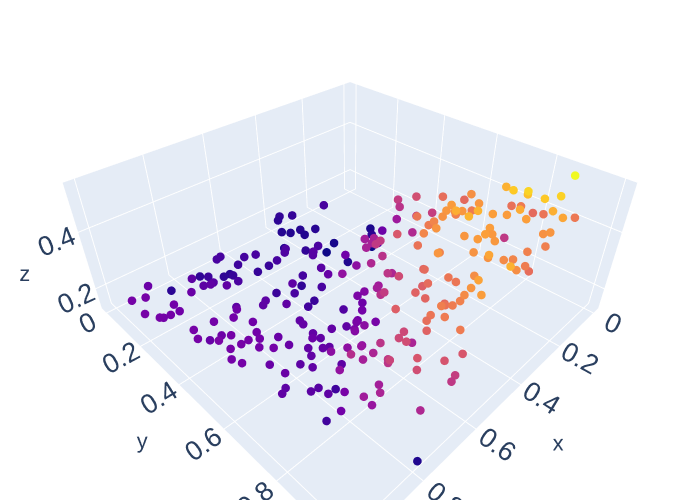

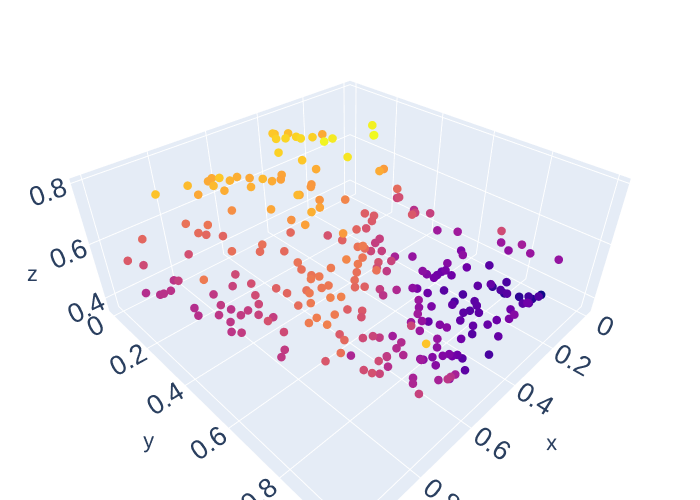

In [15]:
scatter(x_data3[:,0],x_data3[:,1],y_data3[:,0], size = 5, color = y_data3[:,0])
scatter(x_data3[:,0],x_data3[:,1],y_data3[:,1], size = 5, color = y_data3[:,1])

### A simple kernel definition
It is vital in the multi-task case to think hard about kernel design. The kernel is now a function
over X x X x T x T, where X is the input and T is the output space. Print the input into the kernel, it will have the dimensionality of this cartesian product space. The default kernel is just a Matern kernel in input and output directions. 

In [16]:
#As imple kernel, that won't lead to good performance because its stationary
def mkernel(x1,x2,hps,obj):
    d = obj.get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

### Initialization

#### (a) Default behavior

In [17]:
from fvgp import fvGP

my_gp2 = fvGPOptimizer(x_data3,y_data3,)
print("Global Training in progress")
my_gp2.train(max_iter = 2)

Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:249: UserWarning:

Hyperparameters initialized to a vector of ones.

/home/marcus/Coding/fvGP/fvgp/gp.py:295: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.

/home/marcus/Coding/fvGP/fvgp/gp.py:558: UserWarning:

Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions



array([0.11044617, 3.72888973, 8.25306986, 2.63491759])

#### (b) Simple custom kernel

In [18]:
#A simple kernel, that won't lead to good performance because it's stationary
from gpcam.kernels import *
def mkernel(x1,x2,hps):
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])

In [19]:
my_gp2 = fvGPOptimizer(x_data3,y_data3,
              init_hyperparameters=np.ones((2)), kernel_function=mkernel
             )
print("Global Training in progress")


bounds = np.array([[0.01,1.],[0.01,1.]])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 2)

Global Training in progress


array([1., 1.])

#### (c) Deep kernel

In [20]:
from gpcam.deep_kernel_network import *
iset_dim = 3
gp_deep_kernel_layer_width = 5
n = Network(iset_dim, gp_deep_kernel_layer_width)
print(n.number_of_hps)

def deep_multi_task_kernel(x1, x2, hps):  # pragma: no cover
    signal_var = hps[0]
    length_scale = hps[1]
    hps_nn = hps[2:]
    w1_indices = np.arange(0, gp_deep_kernel_layer_width * iset_dim)
    last = gp_deep_kernel_layer_width * iset_dim
    w2_indices = np.arange(last, last + gp_deep_kernel_layer_width ** 2)
    last = last + gp_deep_kernel_layer_width ** 2
    w3_indices = np.arange(last, last + gp_deep_kernel_layer_width * iset_dim)
    last = last + gp_deep_kernel_layer_width * iset_dim
    b1_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b2_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b3_indices = np.arange(last, last + iset_dim)

    n.set_weights(hps_nn[w1_indices].reshape(gp_deep_kernel_layer_width, iset_dim),
                  hps_nn[w2_indices].reshape(gp_deep_kernel_layer_width, gp_deep_kernel_layer_width),
                  hps_nn[w3_indices].reshape(iset_dim, gp_deep_kernel_layer_width))
    n.set_biases(hps_nn[b1_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b2_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b3_indices].reshape(iset_dim))
    x1_nn = n.forward(x1)
    x2_nn = n.forward(x2)
    d = get_distance_matrix(x1_nn, x2_nn)
    k = signal_var * matern_kernel_diff1(d, length_scale)
    return k


my_gp2 = fvGPOptimizer(x_data3,y_data3,
              init_hyperparameters=np.ones((n.number_of_hps+2))*0.1, kernel_function=deep_multi_task_kernel
             )
print("Global Training in progress")


bounds = np.zeros((n.number_of_hps+2,2))
bounds[0] = np.array([0.01,1.])
bounds[1] = np.array([0.1,1.])
bounds[2:] = np.array([-1,1])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 1000, method = "mcmc")

68
Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:295: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.



array([ 0.25539675,  0.17129587, -0.65938495,  0.16091294,  0.11069382,
       -0.08419946,  0.06556926,  0.2354721 ,  0.49937482, -0.00751786,
        0.43048404, -0.10004003,  0.86908431,  0.74715146,  0.47073369,
        0.56732885, -0.19408402,  0.01641236,  0.30177694,  0.07887782,
        0.33992926, -0.21274777, -0.04784063, -0.24191432, -0.02922784,
        0.65518697,  0.40075592,  0.28057941,  0.63456724, -0.05549874,
        0.3242932 , -0.49769152,  0.15357941,  0.48023221,  0.043102  ,
        0.1731913 , -0.62093939,  0.03569144,  0.05053827, -0.06473352,
        0.14123273,  0.08925234,  0.27650667,  0.63357497, -0.19360413,
       -0.0573718 , -0.13162881,  0.24293689, -0.03124989,  0.44891181,
        0.31840532, -0.34937577,  0.37443888,  0.59114578, -0.45721795,
        0.26254833,  0.161027  ,  0.45772778,  0.52992492, -0.23069584,
        0.24939665, -0.24499682, -0.06724856,  0.09099415,  0.07050899,
        0.3280387 , -0.35101849,  0.35860315,  0.17561375, -0.33

### Prediction

In [21]:
mean = my_gp2.posterior_mean(x_pred3D)["m(x)"]
var =  my_gp2.posterior_covariance(x_pred3D)["v(x)"]

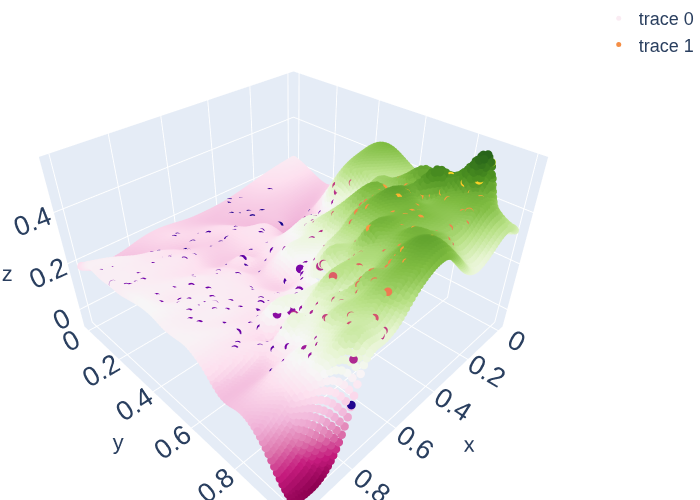

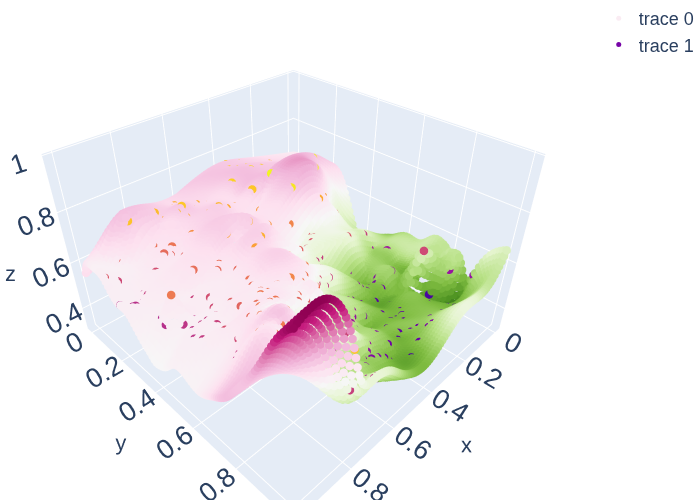

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0],y=x_pred3D[:,1], z=mean[:,0],
                             mode='markers',marker=dict(color=mean[:,0], size = 5)))
fig.add_trace(go.Scatter3d(x=x_data3[:,0], y=x_data3[:,1] , z=y_data3[:,0],
                           mode='markers',marker=dict(color=y_data3[:,0], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()



fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0],y=x_pred3D[:,1], z=mean[:,1],
                             mode='markers',marker=dict(color=mean[:,0], size = 5)))
fig.add_trace(go.Scatter3d(x=x_data3[:,0], y=x_data3[:,1] , z=y_data3[:,1],
                           mode='markers',marker=dict(color=y_data3[:,1], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()



In [23]:
print("n=1")
my_gp2.ask(np.array([[0,1],[0,1]]), n = 1, max_iter=2,pop_size=2, info = True,
           acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 1, max_iter=2,pop_size=2, info = True,
           acquisition_function = 'relative information entropy', x_out = np.array([0.,1.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 1, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'variance', x_out = np.array([0.,1.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 1, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'total correlation', x_out = np.array([0.,1.]), vectorized = True)

print("n>1")
my_gp2.ask(np.array([[0,1],[0,1]]), n = 4, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 5, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'relative information entropy', x_out = np.array([0.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 3, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'variance', x_out = np.array([0.,1.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1]]), n = 2, max_iter=2,pop_size=2,info = True,
           acquisition_function = 'total correlation', vectorized = True)



n=1
differential_evolution step 1: f(x)= 192.82926765408388
differential_evolution step 2: f(x)= 192.82926765408388
differential_evolution step 1: f(x)= 14.805966707541664
differential_evolution step 2: f(x)= 14.805966707541664
differential_evolution step 1: f(x)= -0.0019335320758812613
differential_evolution step 2: f(x)= -0.0026451486437992777


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer_base.py:425: UserWarning:

Set vectorized=False for total corr. or rel. inf. entropy.



differential_evolution step 1: f(x)= 4.56655227590295
differential_evolution step 2: f(x)= 4.56655227590295
n>1


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer_base.py:421: UserWarning:

You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'.



differential_evolution step 1: f(x)= 17.528880551477585
differential_evolution step 2: f(x)= 17.528880551477585
differential_evolution step 1: f(x)= 400.1585354364761
differential_evolution step 2: f(x)= 400.1585354364761
differential_evolution step 1: f(x)= 11.103169954801388
differential_evolution step 2: f(x)= 11.103169954801388
differential_evolution step 1: f(x)= 8.702824714436588
differential_evolution step 2: f(x)= 8.702824714436588


{'x': array([[0.97406894, 0.63830072],
        [0.5931044 , 0.28011756]]),
 'f_a(x)': array([-8.70282471]),
 'opt_obj': None}